In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchxrayvision as xrv
import kagglehub
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report


# Download dataset from Kaggle
dataset_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
dataset_path = "/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"

# Define dataset paths
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

def count_images(directory):
    categories = ["NORMAL", "PNEUMONIA"]
    for category in categories:
        path = os.path.join(directory, category)
        print(f"{category}: {len(os.listdir(path))} images")

print("Train set distribution:")
count_images(train_dir)
print("Validation set distribution:")
count_images(val_dir)
print("Test set distribution:")
count_images(test_dir)


Train set distribution:
NORMAL: 1341 images
PNEUMONIA: 3875 images
Validation set distribution:
NORMAL: 8 images
PNEUMONIA: 8 images
Test set distribution:
NORMAL: 234 images
PNEUMONIA: 390 images


### Data Transformations

In [ ]:
class PneumoniaDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.data = []
        self.labels = []

        for label, category in enumerate(["NORMAL", "PNEUMONIA"]):
            category_path = os.path.join(directory, category)
            for img_name in os.listdir(category_path):
                self.data.append(os.path.join(category_path, img_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("L")  # Convert to grayscale

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)


In [ ]:
# Basic transforms (resize + tensor + normalize)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = PneumoniaDataset(train_dir, transform=train_transform)
val_dataset = PneumoniaDataset(val_dir, transform=val_transform)
test_dataset = PneumoniaDataset(test_dir, transform=val_transform)


#     EXPLORATORY DATA ANALYSIS (EDA)


In [ ]:
# 1. Check dataset size
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 5216
Validation dataset size: 16
Test dataset size: 624


## Count Plot

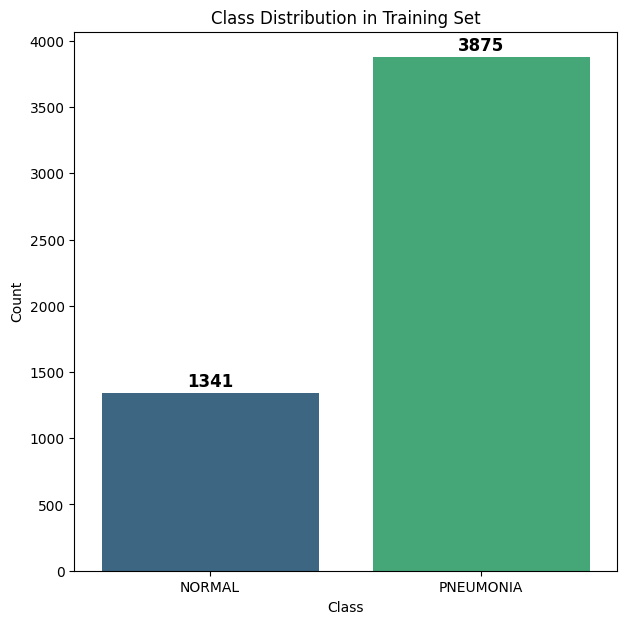

In [ ]:
# Create the count plot
plt.figure(figsize=(7, 7))
ax = sns.countplot(x=train_dataset.labels, palette="viridis")

# Annotate bars with the count value
counts = np.bincount(train_dataset.labels)  # Count occurrences of 0 (NORMAL) and 1 (PNEUMONIA)
for i, count in enumerate(counts):
    ax.text(i, count + 50, str(count), ha='center', fontsize=12, fontweight='bold')  # Adjust position

# Set labels and title
plt.xticks(ticks=[0, 1], labels=["NORMAL", "PNEUMONIA"])
plt.title("Class Distribution in Training Set")
plt.ylabel("Count")
plt.xlabel("Class")

plt.show()


## Pixel intensity distribution Plot


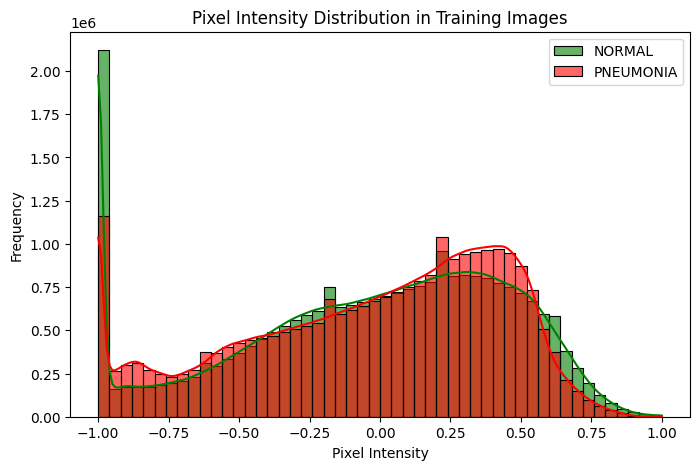

In [ ]:
# Collect pixel intensities for both classes (limiting to 500 images per class)
normal_pixels = torch.cat([train_dataset[i][0].flatten() for i in range(len(train_dataset)) if train_dataset.labels[i] == 0][:500]).numpy()
pneumonia_pixels = torch.cat([train_dataset[i][0].flatten() for i in range(len(train_dataset)) if train_dataset.labels[i] == 1][:500]).numpy()

# Plot pixel intensity distribution
plt.figure(figsize=(8, 5))
sns.histplot(normal_pixels, bins=50, kde=True, color='green', label="NORMAL", alpha=0.6)
sns.histplot(pneumonia_pixels, bins=50, kde=True, color='red', label="PNEUMONIA", alpha=0.6)
plt.title("Pixel Intensity Distribution in Training Images")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()


### Visualizing 5 NORMAL and 5 PNEUMONIA images


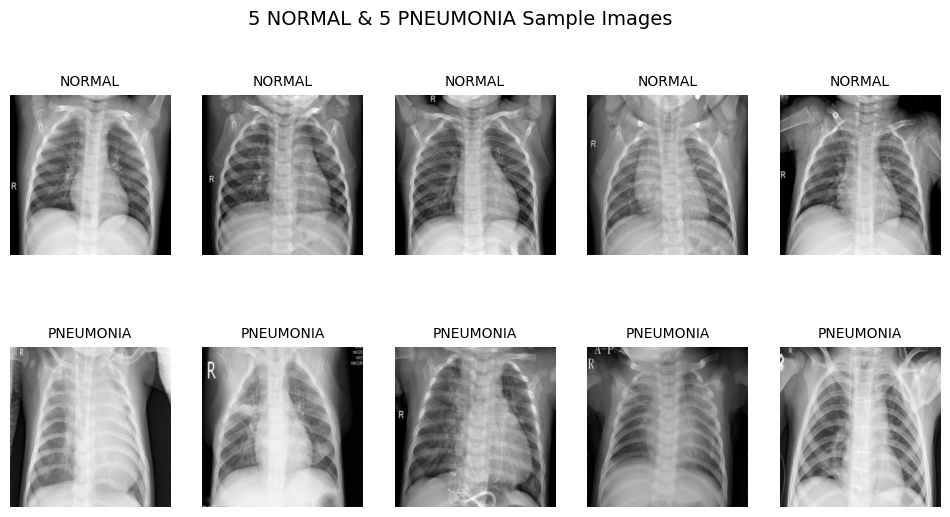

In [ ]:
normal_images = []
pneumonia_images = []

for i in range(len(train_dataset)):
    img, label = train_dataset[i]
    if label == 0 and len(normal_images) < 5:
        normal_images.append((img, label))
    elif label == 1 and len(pneumonia_images) < 5:
        pneumonia_images.append((img, label))

    if len(normal_images) == 5 and len(pneumonia_images) == 5:
        break  # Stop when we have 5 of each

# Combine both lists
selected_images = normal_images + pneumonia_images

# Plot the images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    img, label = selected_images[i]
    ax.imshow(img[0], cmap="gray")  # img[0] to get the grayscale channel
    ax.set_title("NORMAL" if label == 0 else "PNEUMONIA", fontsize=10)
    ax.axis("off")

plt.suptitle("5 NORMAL & 5 PNEUMONIA Sample Images", fontsize=14)
plt.show()


In [ ]:
# Count class occurrences
normal_count = sum(1 for label in train_dataset.labels if label == 0)
pneumonia_count = sum(1 for label in train_dataset.labels if label == 1)

print("Normal Count:", normal_count)
print("Pneumonia Count:", pneumonia_count)

# Compute class weights which is inversely proportional to its frequency
class_weights = [1.0 / normal_count, 1.0 / pneumonia_count]
print("Class Weights:", class_weights)

# Create a list of sample weights for each image
sample_weights = [class_weights[int(label)] for label in train_dataset.labels]

# Create the WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoaders (train uses sampler, val/test use default)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


Normal Count: 1341
Pneumonia Count: 3875
Class Weights: [0.0007457121551081282, 0.00025806451612903227]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = xrv.models.DenseNet(weights="densenet121-res224-all")
model.op_threshs = None  # Remove thresholds
# Replace final layer for binary classification
model.classifier = nn.Linear(model.classifier.in_features, 1)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)

# Optional: Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)


Using device: cuda


In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=10):
    train_losses, val_losses = [], []
    train_accs, val_accs, val_aucs = [], [], []

    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_train_labels, all_train_preds = [], []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.unsqueeze(1).float().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()

            running_loss += loss.item()
            preds = (torch.sigmoid(outputs).detach() > 0.5).float()

            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(preds.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(all_train_labels, all_train_preds)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        running_loss = 0.0
        all_val_labels, all_val_preds, all_val_probs = [], [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.unsqueeze(1).float().to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                probs = torch.sigmoid(outputs).cpu().numpy()
                preds = (probs > 0.5).astype(float)

                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(preds)
                all_val_probs.extend(probs)

        val_loss = running_loss / len(val_loader)
        val_acc = accuracy_score(all_val_labels, all_val_preds)
        val_auc = roc_auc_score(all_val_labels, all_val_probs)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_aucs.append(val_auc)

        # Step the scheduler (if used)
        if scheduler:
            scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, AUC: {val_auc:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

    # Save best model checkpoint
    if best_model_state is not None:
        torch.save(best_model_state, "pneumonia_model.pth")
        print("Best model saved with Val Loss:", best_val_loss)

    # Print final classification report on validation
    print("\nFinal Validation Classification Report:\n")
    print(classification_report(all_val_labels, all_val_preds, digits=4))

    return train_losses, val_losses, train_accs, val_accs, val_aucs

train_losses, val_losses, train_accs, val_accs, val_aucs = train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=15
)

Epoch 1/15 - Training: 100%|██████████| 163/163 [01:17<00:00,  2.11it/s]


Epoch [1/15] | Train Loss: 0.6870, Train Acc: 0.6400 | Val Loss: 0.6736, Val Acc: 0.7500, AUC: 0.8750


Epoch 2/15 - Training: 100%|██████████| 163/163 [01:16<00:00,  2.14it/s]


Epoch [2/15] | Train Loss: 0.6599, Train Acc: 0.8685 | Val Loss: 0.6520, Val Acc: 0.9375, AUC: 0.9219


Epoch 3/15 - Training: 100%|██████████| 163/163 [01:14<00:00,  2.19it/s]


Epoch [3/15] | Train Loss: 0.6288, Train Acc: 0.8988 | Val Loss: 0.6263, Val Acc: 0.9375, AUC: 0.9375


Epoch 4/15 - Training: 100%|██████████| 163/163 [01:15<00:00,  2.16it/s]


Epoch [4/15] | Train Loss: 0.5926, Train Acc: 0.9101 | Val Loss: 0.5944, Val Acc: 0.9375, AUC: 0.9531


Epoch 5/15 - Training: 100%|██████████| 163/163 [01:15<00:00,  2.15it/s]


Epoch [5/15] | Train Loss: 0.5536, Train Acc: 0.9241 | Val Loss: 0.5651, Val Acc: 0.9375, AUC: 0.9531


Epoch 6/15 - Training: 100%|██████████| 163/163 [01:13<00:00,  2.21it/s]


Epoch [6/15] | Train Loss: 0.5113, Train Acc: 0.9387 | Val Loss: 0.5376, Val Acc: 0.9375, AUC: 0.9531


Epoch 7/15 - Training: 100%|██████████| 163/163 [01:16<00:00,  2.13it/s]


Epoch [7/15] | Train Loss: 0.4732, Train Acc: 0.9408 | Val Loss: 0.5136, Val Acc: 0.9375, AUC: 0.9688


Epoch 8/15 - Training: 100%|██████████| 163/163 [01:16<00:00,  2.13it/s]


Epoch [8/15] | Train Loss: 0.4298, Train Acc: 0.9534 | Val Loss: 0.4835, Val Acc: 0.9375, AUC: 0.9844


Epoch 9/15 - Training: 100%|██████████| 163/163 [01:16<00:00,  2.14it/s]


Epoch [9/15] | Train Loss: 0.3914, Train Acc: 0.9567 | Val Loss: 0.4782, Val Acc: 0.9375, AUC: 0.9844


Epoch 10/15 - Training: 100%|██████████| 163/163 [01:13<00:00,  2.20it/s]


Epoch [10/15] | Train Loss: 0.3508, Train Acc: 0.9659 | Val Loss: 0.4633, Val Acc: 0.8750, AUC: 1.0000


Epoch 11/15 - Training: 100%|██████████| 163/163 [01:13<00:00,  2.20it/s]


Epoch [11/15] | Train Loss: 0.3207, Train Acc: 0.9668 | Val Loss: 0.4424, Val Acc: 0.8750, AUC: 1.0000


Epoch 12/15 - Training: 100%|██████████| 163/163 [01:18<00:00,  2.08it/s]


Epoch [12/15] | Train Loss: 0.2882, Train Acc: 0.9726 | Val Loss: 0.4602, Val Acc: 0.7500, AUC: 1.0000


Epoch 13/15 - Training: 100%|██████████| 163/163 [01:20<00:00,  2.03it/s]


Epoch [13/15] | Train Loss: 0.2701, Train Acc: 0.9716 | Val Loss: 0.4004, Val Acc: 0.9375, AUC: 1.0000


Epoch 14/15 - Training: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]


Epoch [14/15] | Train Loss: 0.2485, Train Acc: 0.9749 | Val Loss: 0.4437, Val Acc: 0.7500, AUC: 1.0000


Epoch 15/15 - Training: 100%|██████████| 163/163 [01:15<00:00,  2.16it/s]


Epoch [15/15] | Train Loss: 0.2371, Train Acc: 0.9726 | Val Loss: 0.3565, Val Acc: 0.9375, AUC: 1.0000
Best model saved with Val Loss: 0.3564857840538025

Final Validation Classification Report:

              precision    recall  f1-score   support

         0.0     1.0000    0.8750    0.9333         8
         1.0     0.8889    1.0000    0.9412         8

    accuracy                         0.9375        16
   macro avg     0.9444    0.9375    0.9373        16
weighted avg     0.9444    0.9375    0.9373        16



## Loss and Auc-Roc Plots

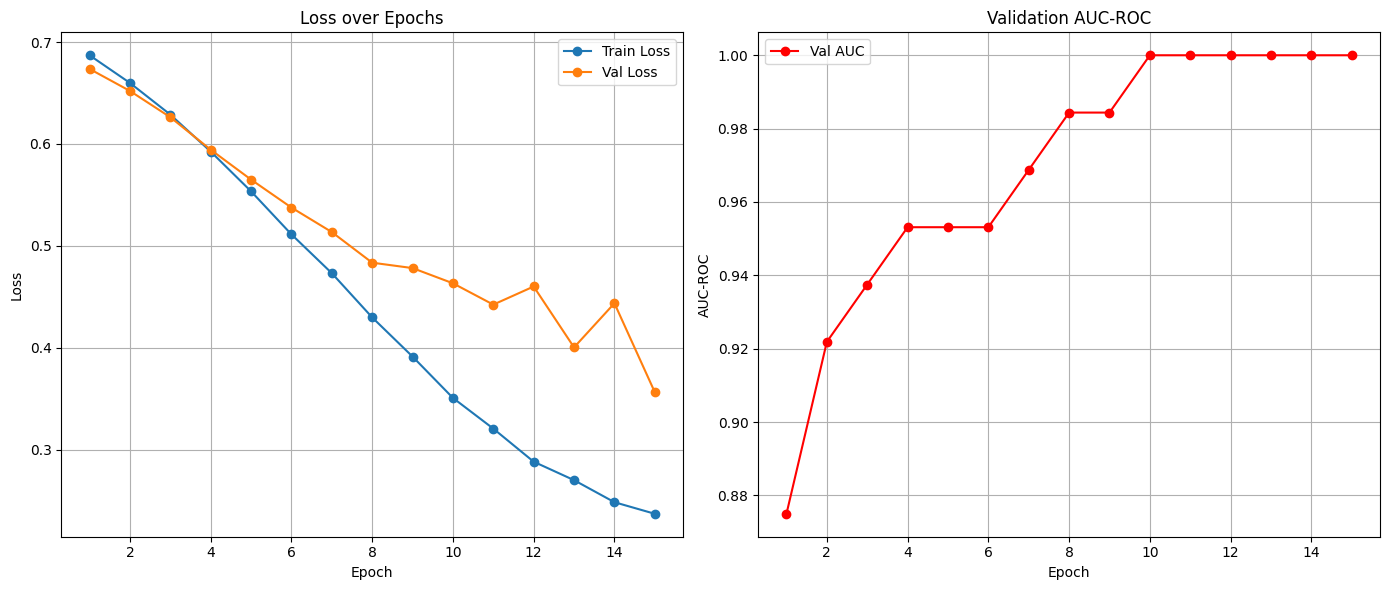

In [ ]:
epochs = range(1, len(train_losses) + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Loss
axes[0].plot(epochs, train_losses, label="Train Loss", marker="o")
axes[0].plot(epochs, val_losses, label="Val Loss", marker="o")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss over Epochs")
axes[0].legend()
axes[0].grid(True)

# Plot AUC-ROC
axes[1].plot(epochs, val_aucs, label="Val AUC", marker="o", color="red")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("AUC-ROC")
axes[1].set_title("Validation AUC-ROC")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


### Prediction time

Using device: cuda


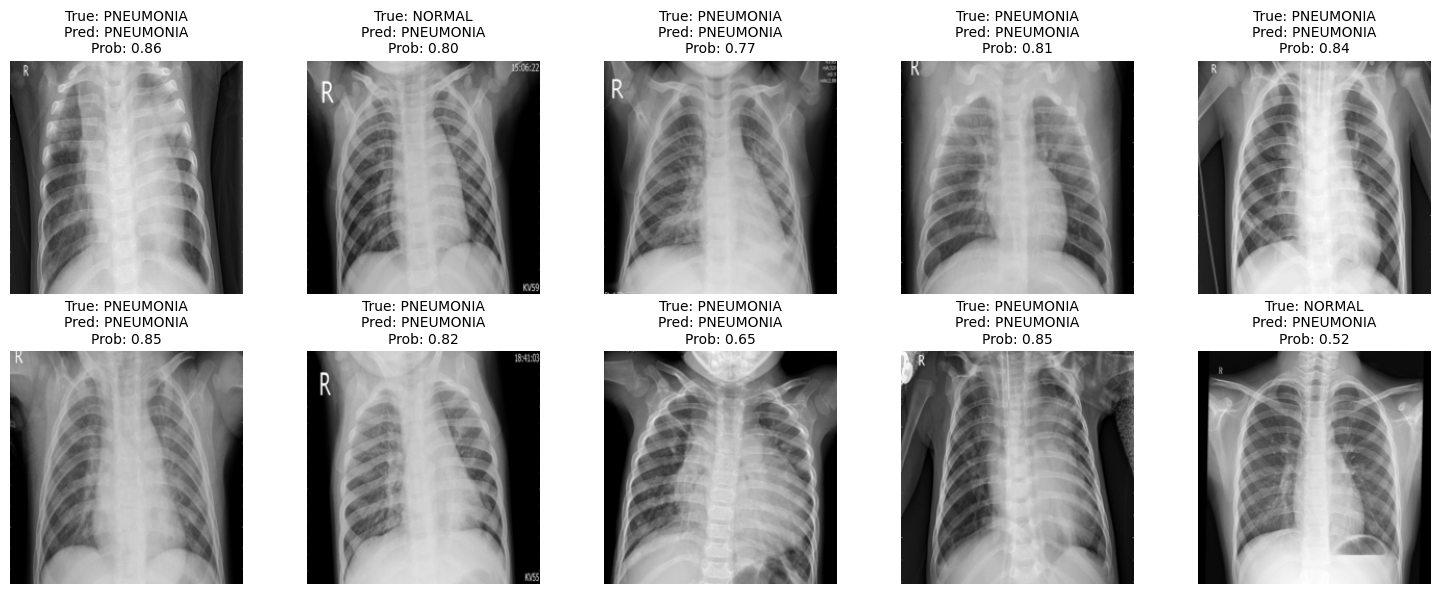

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import torchxrayvision as xrv

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the test dataset directory (adjust if needed)
dataset_path = "/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"
test_dir = os.path.join(dataset_path, "test")

# Define transform (should be same as used during training/validation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Custom Dataset Class
class PneumoniaDataset(torch.utils.data.Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.data = []
        self.labels = []
        for label, category in enumerate(["NORMAL", "PNEUMONIA"]):
            category_path = os.path.join(directory, category)
            for img_name in os.listdir(category_path):
                self.data.append(os.path.join(category_path, img_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        # Convert to grayscale
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)

# Load test dataset
test_dataset = PneumoniaDataset(test_dir, transform=val_transform)

# Load the saved trained model
model = xrv.models.DenseNet(weights="densenet121-res224-all")
# Remove thresholds from multi-label classification
model.op_threshs = None
# IMPORTANT: Define the classifier exactly as used during training (with dropout)
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.classifier.in_features, 1)
)
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Pneumonia_detection/best_pneumonia_model.pth", map_location=device))
model = model.to(device)
model.eval()

# Class names mapping
class_names = ["NORMAL", "PNEUMONIA"]

# Select 10 random indices from the test dataset
random_indices = random.sample(range(len(test_dataset)), 10)

# Plot predictions for 10 random test images
plt.figure(figsize=(15, 6))
for i, idx in enumerate(random_indices):
   # true_label is a tensor
    image, true_label = test_dataset[idx]
    # Add batch dimension
    image_tensor = image.unsqueeze(0).to(device)

    # Predict using the model
    with torch.no_grad():
        output = model(image_tensor)
        probability = torch.sigmoid(output).item()
        pred_label = 1 if probability > 0.5 else 0

    # Denormalize image for visualization (reverse normalization)
    # Given normalization: (x - 0.5) / 0.5, so reverse: x * 0.5 + 0.5
    image_np = image.cpu().squeeze().numpy()
    # now in [0, 1] range
    image_denorm = (image_np * 0.5) + 0.5

    ax = plt.subplot(2, 5, i+1)
    plt.imshow(image_denorm, cmap="gray")
    plt.title(f"True: {class_names[int(true_label)]}\nPred: {class_names[pred_label]}\nProb: {probability:.2f}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()
